# **Implementando uma rede neural do tipo multilayer perceptron com número variável de camadas ocultas e neurônios por camada oculta e o algoritmo backpropagation sem usar o pytorch**

## **NumPy, Matplotlib e MNIST: bibliotecas matemáticas e dataset de reconhecimento de dígitos**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

## **Normalization: adaptando os dados em escala para valores entre 0 e 1 e estabilizando a eficiência do treinamento da rede neural**

In [ ]:
x_train = x_train.reshape(x_train.shape[0], -1).T / 255.0
x_test = x_test.reshape(x_test.shape[0], -1).T / 255.0

## **One-Hot Encoding: representando categorias como vetores binários para problemas de classificação com múltiplas classes**

In [ ]:
y_train = np.eye(10)[y_train].T
y_test = np.eye(10)[y_test].T

## **Activation Functions: introduzindo não-linearidade nas saídas das camadas da rede neural, permitindo que ela aprenda relações complexas e propague eficientemente os gradientes durante o treinamento**

**Função de ativação ReLU.**
<br><br>
A função ReLU é definida como:
$$
f(z) = \max(0, z)
$$
<br>
Ela introduz não-linearidade ao descartar valores negativos, ativando apenas quando o input é positivo.
<br><br>
Parâmetros:
* Z: Array de inputs para a função ReLU (valores de pré-ativação).

Retorna:
* A: Array de outputs da função ReLU, onde cada elemento é o máximo entre zero e o elemento correspondente de Z.
* relu_memory: Array de cópias do input Z, armazenada para uso no backward pass.

In [ ]:
def relu(Z):
    A = np.maximum(0, Z)
    relu_memory = Z

    return A, relu_memory

**Backward pass da função de ativação ReLU.**
<br><br>
Durante a retropropagação, a ReLU tem um fluxo de gradientes simples: se o valor de pré-ativação foi positivo, o gradiente é passado de volta inalterado.
Se o valor de pré-ativação foi negativo, o gradiente é definido como zero.
<br><br>
Parâmetros:
* dA: Array de gradientes da função de perda em relação ao output da função ReLU.
* relu_memory: Array de valores de pré-ativação armazenados durante o forward pass.

Retorna:
* dZ: Array de gradientes da função de perda em relação aos valores de pré-ativação Z.

In [ ]:
def relu_backward(dA, relu_memory):
    Z = relu_memory
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    return dZ

**Função de ativação Softmax.**
<br><br>
A função softmax é definida como:
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}, \quad \text{para todo } j
$$
<br>
Ela normaliza os valores de input em uma distribuição de probabilidade, garantindo que a soma das probabilidades para todas as classes seja igual a um.<br><br>
Parâmetros:
* Z: Array de inputs para a função softmax (logits).

Retorna:
* A: Array de outputs da função softmax, onde cada elemento representa a probabilidade da classe correspondente.
* softmax_memory: Array de cópias do input Z, armazenada para uso no backward pass.

In [ ]:
def softmax(Z):
    Z_exp = np.exp(Z)
    Z_sum = np.sum(Z_exp, axis=0, keepdims=True)
    A = Z_exp / Z_sum
    softmax_memory = Z

    return A, softmax_memory

## **Parameters: inicializando os parâmetros da rede neural**

Parâmetros:
* dimensions: Lista de inteiros representando o número de neurônios em cada camada da rede.

Retorna:
* parameters: Dicionário contendo os pesos e biases inicializados para cada camada da rede. As chaves são no formato "Wl" para os pesos e "bl" para os biases, onde 'l' é o número da camada.

In [ ]:
def initialize_parameters(dimensions):
    np.random.seed(2)
    parameters = {}
    L = len(dimensions)

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(dimensions[l], dimensions[l - 1]) * 0.1
        parameters["b" + str(l)] = np.zeros((dimensions[l], 1))

    return parameters

## **Forward Propagation: passando os inputs através das camadas ocultas da rede neural e produzindo uma previsão do modelo**

**Cálculo da saída da camada aplicando a função de ativação especificada aos resultados da operação linear.**
<br><br>
Parâmetros:
* A_prev: Array de ativações da camada anterior.
* W: Array de pesos da camada atual.
* b: Array de biases da camada atual.
* activation: String correspondente à função de ativação a ser aplicada na saída da camada.

Retorna:
* A: Array de ativações da camada atual.
* memory: Tupla contendo os dados necessários para o backward pass. Contém:
  * linear_memory: Tupla contendo os valores de A_prev, W e b.
  * activation_memory: Resultado da operação de ativação Z antes da função de ativação.

In [ ]:
def layer_forward(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    linear_memory = (A_prev, W, b)

    if activation == "relu":
        A, activation_memory = relu(Z)
    elif activation == "softmax":
        A, activation_memory = softmax(Z)

    memory = (linear_memory, activation_memory)

    return A, memory

**Aplicação da propagação direta em todas as camadas, exceto na última, onde a função softmax é aplicada.**
<br><br>
Parâmetros:
* X: Array de inputs da rede neural.
* parameters: Dicionário contendo os parâmetros de todas as camadas da rede.

Retorna:
* AL: Array de ativações da última camada da rede.
* memories: Lista contendo as memórias de cada camada necessárias para o backward pass. Cada elemento da lista é uma tupla contendo os dados necessários para o backward pass de uma camada específica.

In [ ]:
def forward_propagation(X, parameters):
    memories = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        W_l = parameters["W" + str(l)]
        b_l = parameters["b" + str(l)]
        A, memory = layer_forward(A_prev, W_l, b_l, activation="relu")
        memories.append(memory)

    W_L = parameters["W" + str(L)]
    b_L = parameters["b" + str(L)]
    AL, memory = layer_forward(A, W_L, b_L, activation="softmax")

    memories.append(memory)

    return AL, memories

## **Loss Function: avaliando a discrepância entre as previsões do modelo e os valores reais durante o treinamento da rede neural**

Parâmetros:
* AL: Array de previsões da rede neural.
* Y: Array de labels dos dados.

Retorna:
* loss: Valor da função de perda.

In [ ]:
def compute_loss(AL, Y):
    m = Y.shape[1]
    loss = -(1.0 / m) * np.sum(Y * np.log(AL))
    loss = np.squeeze(loss)

    return loss

## **Backward Propagation: calculando os gradientes da função de perda em relação aos parâmetros da rede e ajustando os pesos e biases durante o treinamento**

**Cálculo dos gradientes dos parâmetros da camada e os gradientes em relação à ativação da camada anterior.**
<br><br>
Parâmetros:
* dA: Array de gradientes em relação à ativação da camada atual.
* memory: Tupla contendo os dados necessários para o backward pass.
  * linear_memory: Tupla contendo os valores de A_prev, W e b.
  * activation_memory: Array de resultado da operação de ativação Z antes da função de ativação.

Retorna:
* dA_prev: Array de gradientes em relação à ativação da camada anterior.
* dW: Array de gradientes em relação aos pesos da camada atual.
* db: Array de gradientes em relação aos biases da camada atual.

In [ ]:
def layer_backward(dA, memory):
    linear_memory, activation_memory = memory

    dZ = relu_backward(dA, activation_memory)
    A_prev, W, b = linear_memory
    m = A_prev.shape[1]
    dW = (1.0 / m) * np.matmul(dZ, A_prev.T)
    db = (1.0 / m) * np.sum(dZ, axis=-1, keepdims=True)
    dA_prev = np.matmul(np.transpose(W), dZ)

    return dA_prev, dW, db

**Cálculo dos gradientes dos parâmetros de todas as camadas e os gradientes em relação à ativação da camada anterior para cada camada.**
<br><br>
Parâmetros:
* AL: Array de previsões da rede neural.
* Y: Array de labels dos dados.
* memories: Lista contendo as memórias de cada camada necessárias para o backward pass. Cada elemento da lista é uma tupla contendo os dados necessários para o backward pass de uma camada específica.

Retorna:
* gradients: Dicionário contendo os gradientes dos parâmetros de todas as camadas e os gradientes em relação à ativação da camada anterior para cada camada. As chaves são no formato "dAl", "dWl" e "dbl", onde 'l' é o número da camada.

In [ ]:
def backward_propagation(AL, Y, memories):
    gradients = {}
    L = len(memories)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    current_memory = memories[-1]
    linear_memory, activation_memory = current_memory
    dZ = AL - Y
    A_prev, W, b = linear_memory

    gradients["dA" + str(L - 1)] = np.dot(np.transpose(W), dZ)
    gradients["dW" + str(L)] = (1.0 / m) * np.matmul(dZ, A_prev.T)
    gradients["db" + str(L)] = (1.0 / m) * np.sum(dZ, axis=-1, keepdims=True)

    for l in reversed(range(L - 1)):
        current_memory = memories[l]

        dA_prev_temp, dW_temp, db_temp = layer_backward(gradients["dA" + str(l + 1)], current_memory)
        gradients["dA" + str(l)] = dA_prev_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp

    return gradients

## **Parameters: atualizando os parâmetros da rede neural**

Parâmetros:
* parameters: Dicionário contendo os parâmetros de todas as camadas da rede.
* gradients: Dicionário contendo os gradientes dos parâmetros calculados durante o backward pass. As chaves são no formato "dWl" para os gradientes dos pesos e "dbl" para os gradientes dos biases.
* learning_rate: Taxa de aprendizado que controla o tamanho dos passos durante a atualização dos parâmetros.

Retorna:
* parameters: Dicionário de parâmetros atualizados após a aplicação do gradiente descendente.

In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * gradients["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * gradients["db" + str(l + 1)]

    return parameters

## **Model: treinando a rede neural usando a propagação direta e a propagação reversa para atualizar os parâmetros do modelo**

Parâmetros:
* X: Array de inputs da rede neural.
* Y: Array de labels dos dados.
* dimensions: Lista de inteiros representando o número de neurônios em cada camada da rede.
* learning_rate: Taxa de aprendizado para o algoritmo de otimização do gradiente descendente.
* num_iterations: Número de iterações de treinamento.
* print_loss: Imprime ou não o valor da função de perda durante o treinamento.

Retorna:
* parameters: Dicionário contendo os parâmetros do modelo de rede neural treinado.

In [ ]:
def train_model(X, Y, dimensions, learning_rate, num_iterations, print_loss):
    np.random.seed(2)
    losses = []
    parameters = initialize_parameters(dimensions)

    for i in range(0, num_iterations):
        AL, memories = forward_propagation(X, parameters)
        loss = compute_loss(AL, Y)
        gradients = backward_propagation(AL, Y, memories)
        parameters = update_parameters(parameters, gradients, learning_rate)

        if i % 100 == 0:
            losses.append(loss)

            if print_loss:
                print("Loss after iteration %i: %.2f" % (i, loss))

    plt.plot(np.squeeze(losses))
    plt.grid()
    plt.ylabel("loss")
    plt.xlabel("iterations (per tens)")
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

## **Predictions: calculando e visualizando as previsões para o dataset usando os parâmetros do modelo**

Parâmetros:
* X: Array de inputs para os quais as previsões serão feitas.
* y: Array de labels correspondentes aos inputs.
* parameters: Dicionário contendo os parâmetros do modelo de rede neural treinado.
* mode: String correspondente ao modo de operação do modelo.

Retorna:
* p: Array contendo as previsões feitas pelo modelo para os inputs X.

In [ ]:
def make_predictions(X, y, parameters, mode):
    m = X.shape[1]
    n = len(parameters) // 2

    probabilities, caches = forward_propagation(X, parameters)
    predict = np.argmax(probabilities, axis=0)
    actual = np.argmax(y, axis=0)

    if mode == "train":
        print("Train Accuracy: {:.2%}".format(np.sum((predict == actual) / m)))
    elif mode == "test":
        print("Test Accuracy: {:.2%}".format(np.sum((predict == actual) / m)))

    return predict

Parâmetros:
* x_test: Dataset de teste para os quais as previsões foram feitas.
* y_test: Labels correspondentes ao dataset.
* test: Array de previsões feitas pelo modelo para o dataset de teste.

In [ ]:
def visualize_predictions(x_test, y_test, test):
    fig, axes = plt.subplots(25, 25, figsize=(20, 20))

    for i, ax in enumerate(axes.flat):
        index = i
        k = x_test[:, index].reshape((28, 28))
        ax.imshow(k, cmap="gray")
        ax.set_title("P{predicted} L{actual}".format(predicted=test[index], actual=np.argmax(y_test, axis=0)[index]))
        ax.axis("off")

    plt.subplots_adjust(wspace=1, hspace=1)
    plt.show()

## **SHOWTIME: definindo parâmetros e hiperparâmetros, treinando, testando e visualizando os resultados**

Loss after iteration 0: 2.40
Loss after iteration 100: 1.92
Loss after iteration 200: 1.48
Loss after iteration 300: 1.12
Loss after iteration 400: 0.89
Loss after iteration 500: 0.75
Loss after iteration 600: 0.66
Loss after iteration 700: 0.60
Loss after iteration 800: 0.55
Loss after iteration 900: 0.51
Loss after iteration 1000: 0.49
Loss after iteration 1100: 0.46
Loss after iteration 1200: 0.45
Loss after iteration 1300: 0.43
Loss after iteration 1400: 0.42
Loss after iteration 1500: 0.40
Loss after iteration 1600: 0.39
Loss after iteration 1700: 0.38
Loss after iteration 1800: 0.37
Loss after iteration 1900: 0.37
Loss after iteration 2000: 0.36
Loss after iteration 2100: 0.35
Loss after iteration 2200: 0.35
Loss after iteration 2300: 0.34
Loss after iteration 2400: 0.33
Loss after iteration 2500: 0.33
Loss after iteration 2600: 0.32
Loss after iteration 2700: 0.32
Loss after iteration 2800: 0.32
Loss after iteration 2900: 0.31


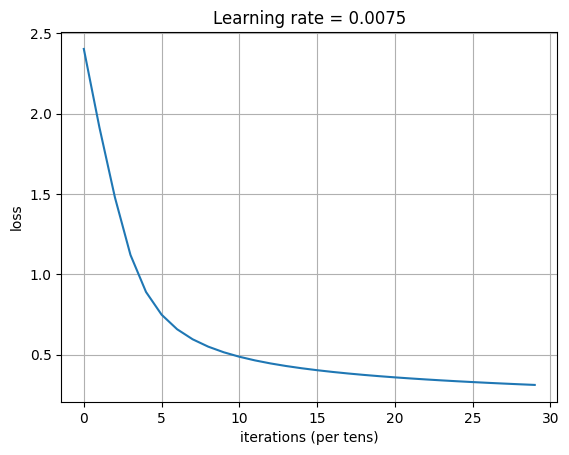

Train Accuracy: 91.09%
Test Accuracy: 91.45%


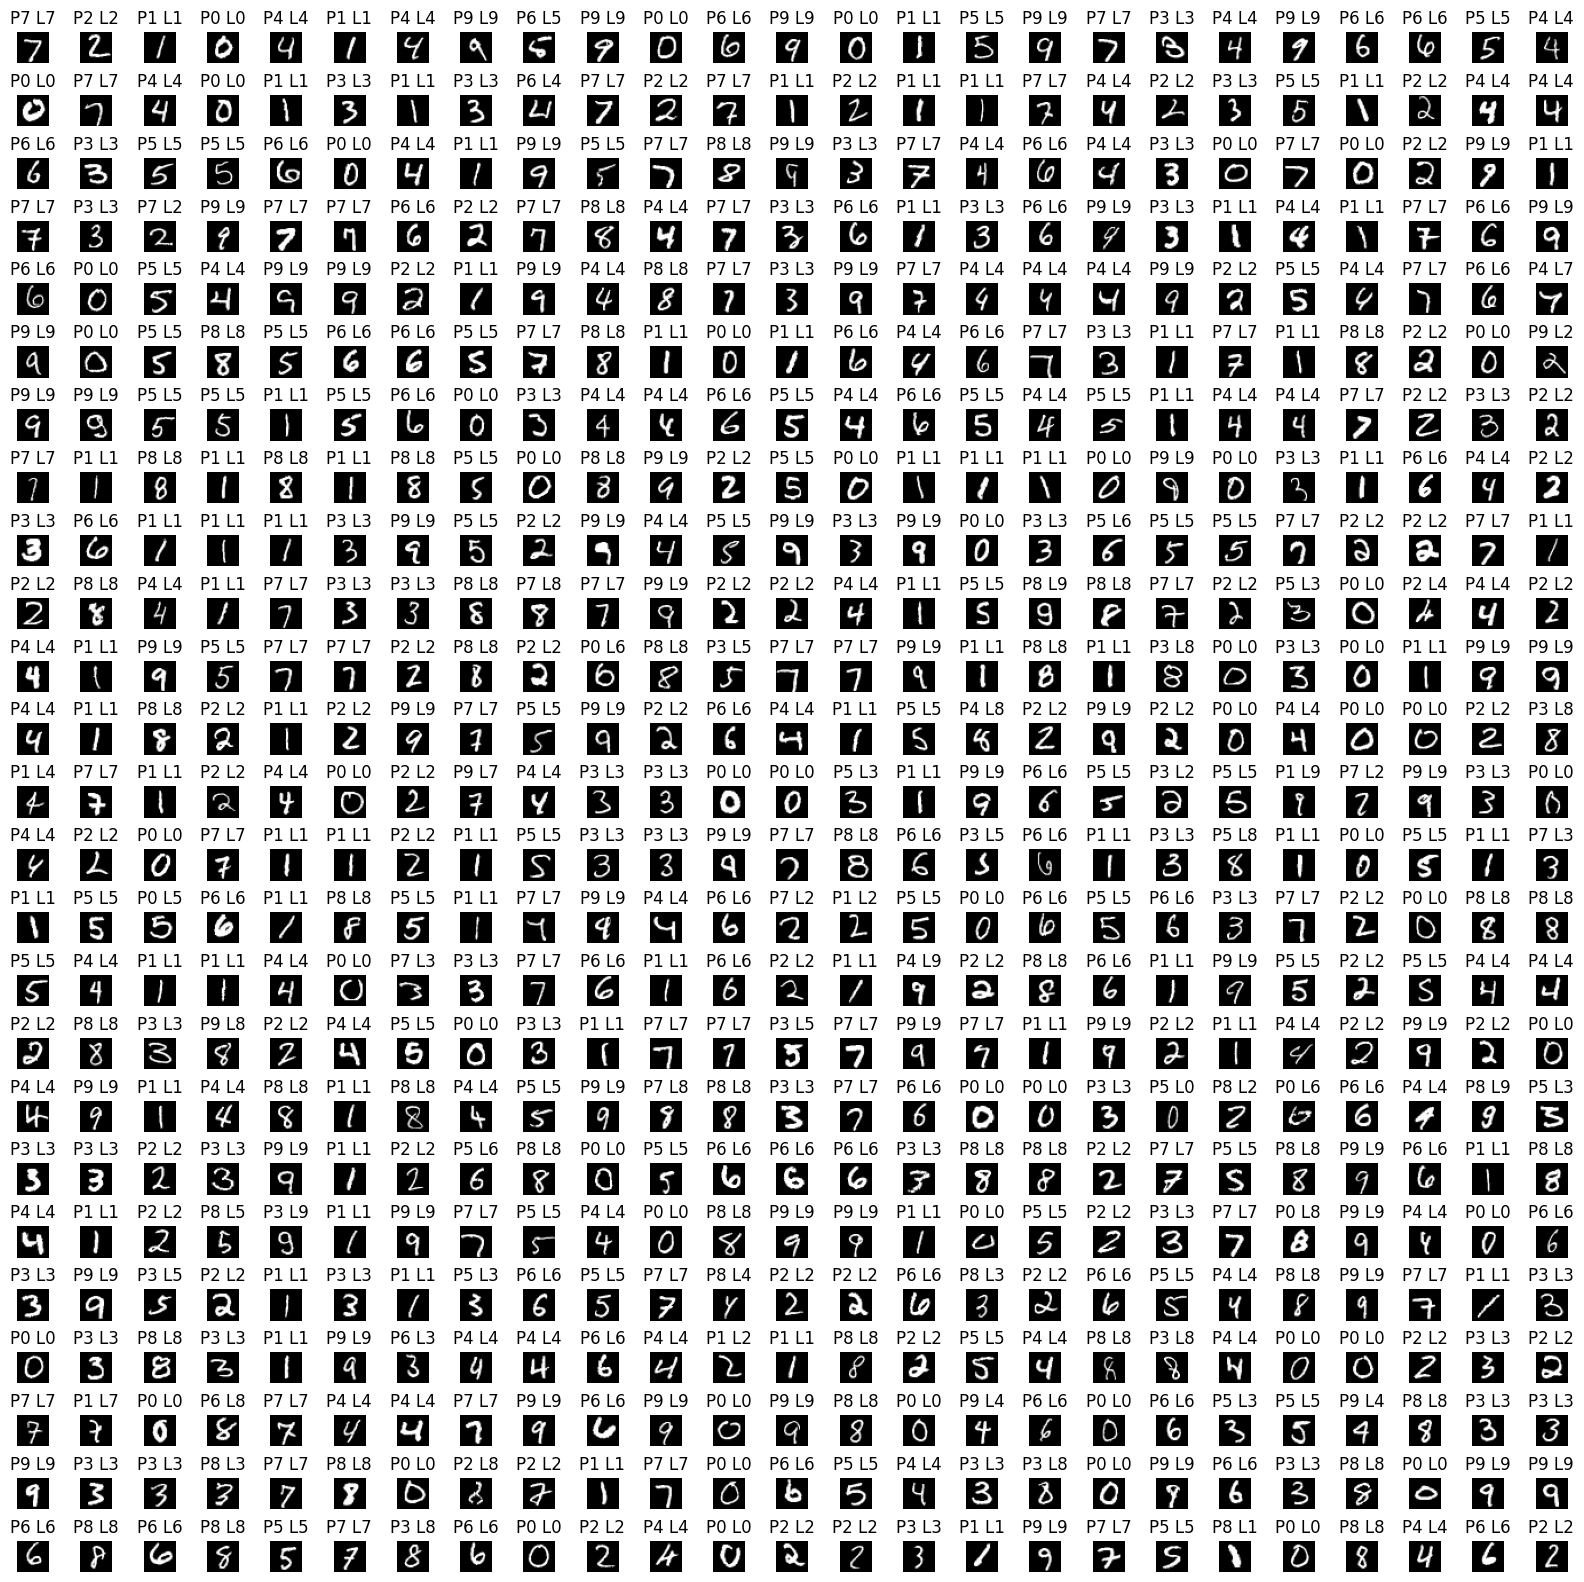

In [ ]:
dimensions = [x_train.shape[0], 256, 64, y_train.shape[0]]
parameters = train_model(x_train, y_train, dimensions, 0.0075, 3000, True)

train = make_predictions(x_train, y_train, parameters, "train")
test = make_predictions(x_test, y_test, parameters, "test")

visualize_predictions(x_test, y_test, test)